In [ ]:
!nvidia-smi

Thu Jul 22 09:05:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3081e72b-70f3-aad9-b556-fb4851f0a2ff)


In [ ]:
# To unzip 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/data_82.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
# import the libraries as shown below
 
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image
import os, time, shutil
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/data_82/train'
valid_path = '/content/data_82/test'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/data_82/train/*')
folders

['/content/data_82/train/5',
 '/content/data_82/train/2',
 '/content/data_82/train/3',
 '/content/data_82/train/4',
 '/content/data_82/train/1',
 '/content/data_82/train/0']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg16_model.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16_model.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Checkpoint's 
# https://keras.io/api/callbacks/model_checkpoint/

filepath="model_vgg16-{epoch:02d}-{val_accuracy:.3f}-{val_loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
callbacks_list = [checkpoint]

In [ ]:
# Use the Image Data Generator to import the images from the dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/data_82/train',
                                                 target_size = (224, 224),
                                                 batch_size = 256,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/data_82/test',
                                            target_size = (224, 224),
                                            batch_size = 256,
                                            class_mode = 'categorical')

Found 7716 images belonging to 6 classes.
Found 1930 images belonging to 6 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute

start = time.time()

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks_list
)
print('\n\n')
print(f'Time: {time.time() - start}')

model.save('VGG16_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
31/31 [==============================] - 215s 5s/step - loss: 1.3974 - accuracy: 0.4864 - val_loss: 1.0612 - val_accuracy: 0.6554

Epoch 00001: val_loss improved from inf to 1.06117, saving model to model_vgg16-01-0.655-1.061.h5
Epoch 2/50
31/31 [==============================] - 132s 4s/step - loss: 0.9836 - accuracy: 0.6878 - val_loss: 0.8377 - val_accuracy: 0.7637

Epoch 00002: val_loss improved from 1.06117 to 0.83772, saving model to model_vgg16-02-0.764-0.838.h5
Epoch 3/50
31/31 [==============================] - 132s 4s/step - loss: 0.8067 - accuracy: 0.7666 - val_loss: 0.7185 - val_accuracy: 0.7855

Epoch 00003: val_loss improved from 0.83772 to 0.71852, saving model to model_vgg16-03-0.785-0.719.h5
Epoch 4/50
31/31 [==============================] - 130s 4s/step - loss: 0.6947 - accuracy: 0.8130 - val_loss: 0.6291 - val_accuracy: 0.8389

Epoch 00004: val_loss improved from 0.71852 to 0.62914, saving model to model_vgg16-04-0.839-0.629.h5
Epoch 5/50
31/31 [==========

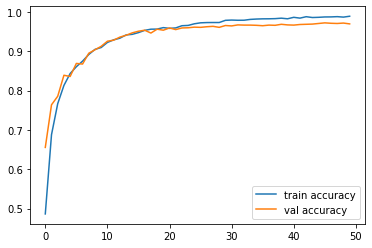

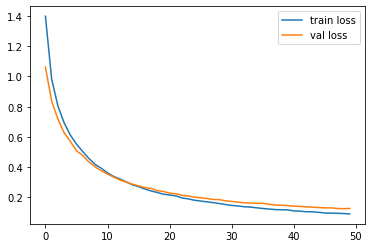

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()
